# Real and Fake News Analysis and Classification

## Data preprocessing

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('corona_fake.csv')

In [3]:
df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [4]:
df.isnull().sum()

title     82
text      10
source    20
label      5
dtype: int64

In [5]:
# Drop Null values
df=df.dropna()

In [6]:
messages=df.copy()
messages.reset_index(inplace=True)
messages['label'].unique()

array(['Fake', 'TRUE', 'fake'], dtype=object)

In [7]:
messages.loc[messages['label'] == 'fake', ['label']] = 'Fake' # Because we had fake and Fake

In [8]:
# Label Encoding
y1=messages['label']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y1=le.fit_transform(y1)
pd.unique(y1)

array([0, 1], dtype=int64)

### Observations:
* 0: Fake , 1: Real

## II/ Analysis

In [9]:
messages.label.value_counts()

TRUE    579
Fake    480
Name: label, dtype: int64

* After some cleaning, we can see that we have 579 true articles and 480 fake ones.

### 1/ Top 15 Sources of Real and Fake News

In [10]:
messages.loc[messages['label'] == 'TRUE'].source.value_counts().nlargest( n=15, keep='first')

https://www.health.harvard.edu/                                                                   102
https://www.nytimes.com/                                                                           62
https://www.globalhealthnow.org/                                                                   56
https://www.who.int/                                                                               48
https://www.cdc.gov/                                                                               38
https://www.cnn.com/                                                                               29
https://www.washingtonpost.com/                                                                    21
https://www.ecdc.europa.eu/                                                                        17
https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/myth-busters     17
https://ec.europa.eu/                                                             

* The true articles were largely collected from Harvard Health Publishing, The New York Times, globalhealthnow, WHO, CDC ...

In [11]:
messages.loc[messages['label'] == 'Fake'].source.value_counts().nlargest( n=15, keep='first')

Facebook                               37
https://www.naturalnews.com/           25
http://orthomolecular.org/             21
https://web.archive.org/               21
https://southfront.org/                17
https://www.globalresearch.ca/         15
https://journal-neo.org/               11
YouTube                                11
https://techstartups.com/              10
https://www.citadelpoliticss.com/      10
https://www.geopolitica.ru/            10
https://childrenshealthdefense.org/     9
https://www.strategic-culture.org/      9
https://www.rt.com/                     9
https://www.activistpost.com/           8
Name: source, dtype: int64

* The fake ones were collected from Facebook and instagram posts , also from website called Natural News, an alternative medicine website called orthomolecular.org.

### 2/ Word Cloud

Now let's take a look at the frequently occuring words in the data by creating a word cloud on the 'text' column.

In [12]:
import requests
from wordcloud import WordCloud, STOPWORDS  
import numpy as np
import matplotlib.pyplot as plt

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

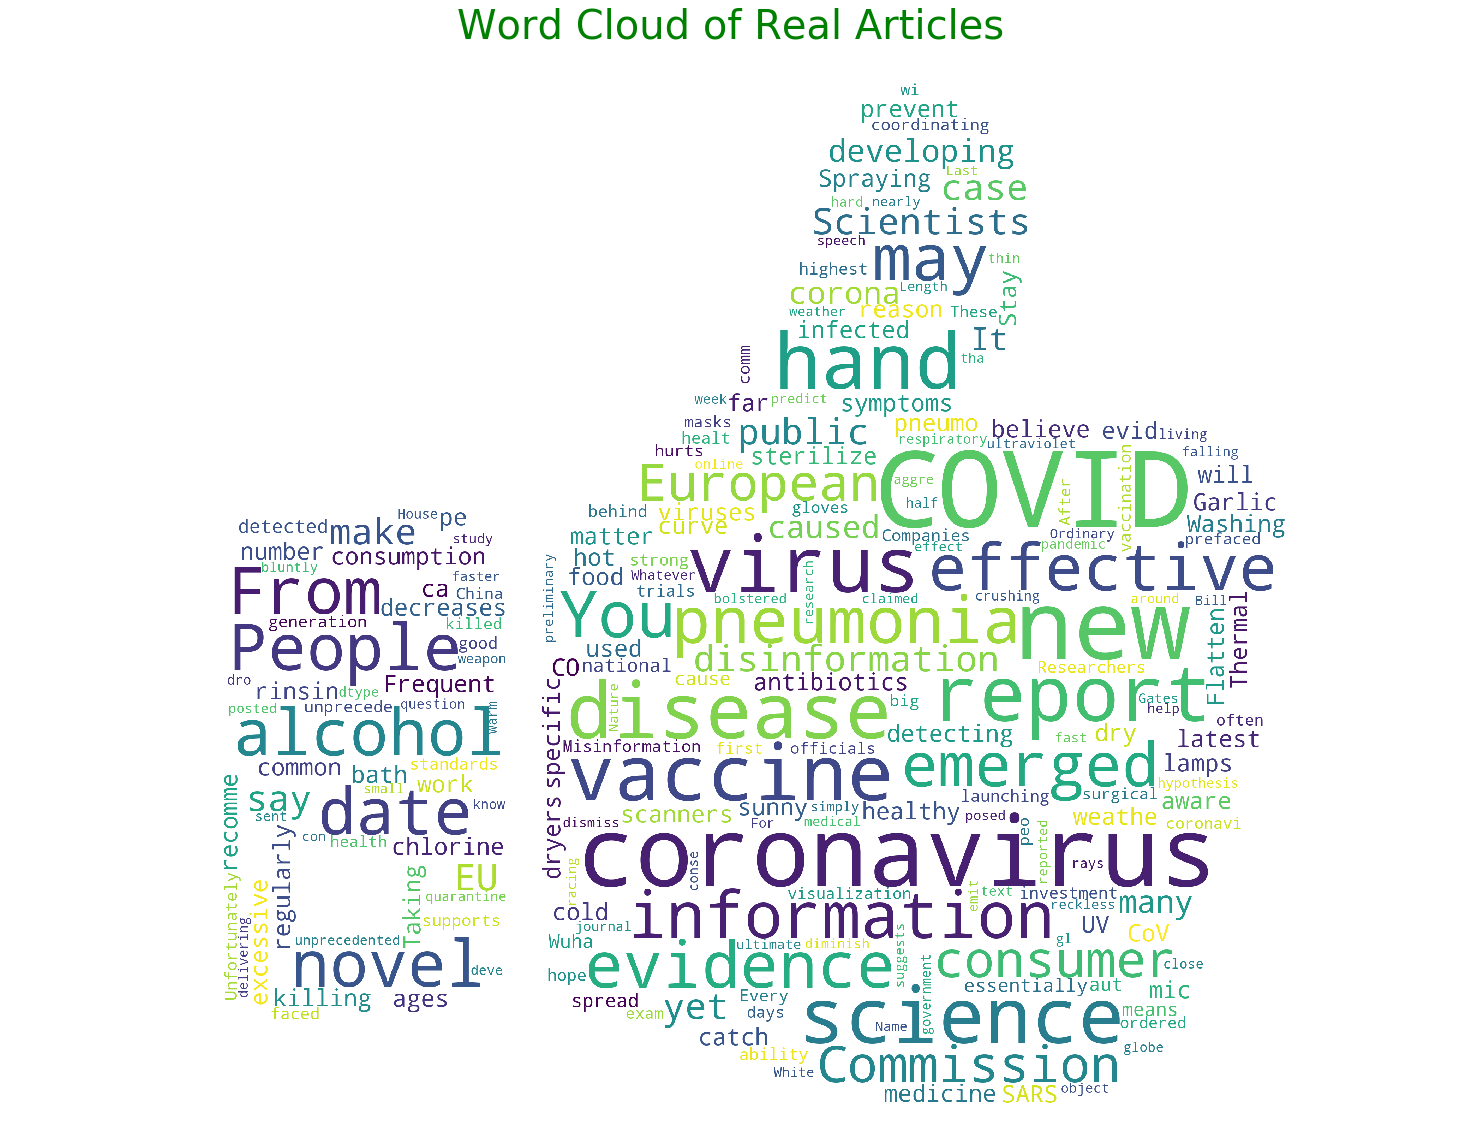

In [13]:
#Word cloud for real words
from PIL import Image
from io import BytesIO
response = requests.get('https://raw.githubusercontent.com/manojknit/Natural_Language_Processing/master/images/upvote.png')
upvote_mask = np.array(Image.open(BytesIO(response.content)))
plot_wordcloud(messages[messages["label"]=="TRUE"]["text"], upvote_mask, max_words=300000, max_font_size=300, title="Word Cloud of Real Articles")

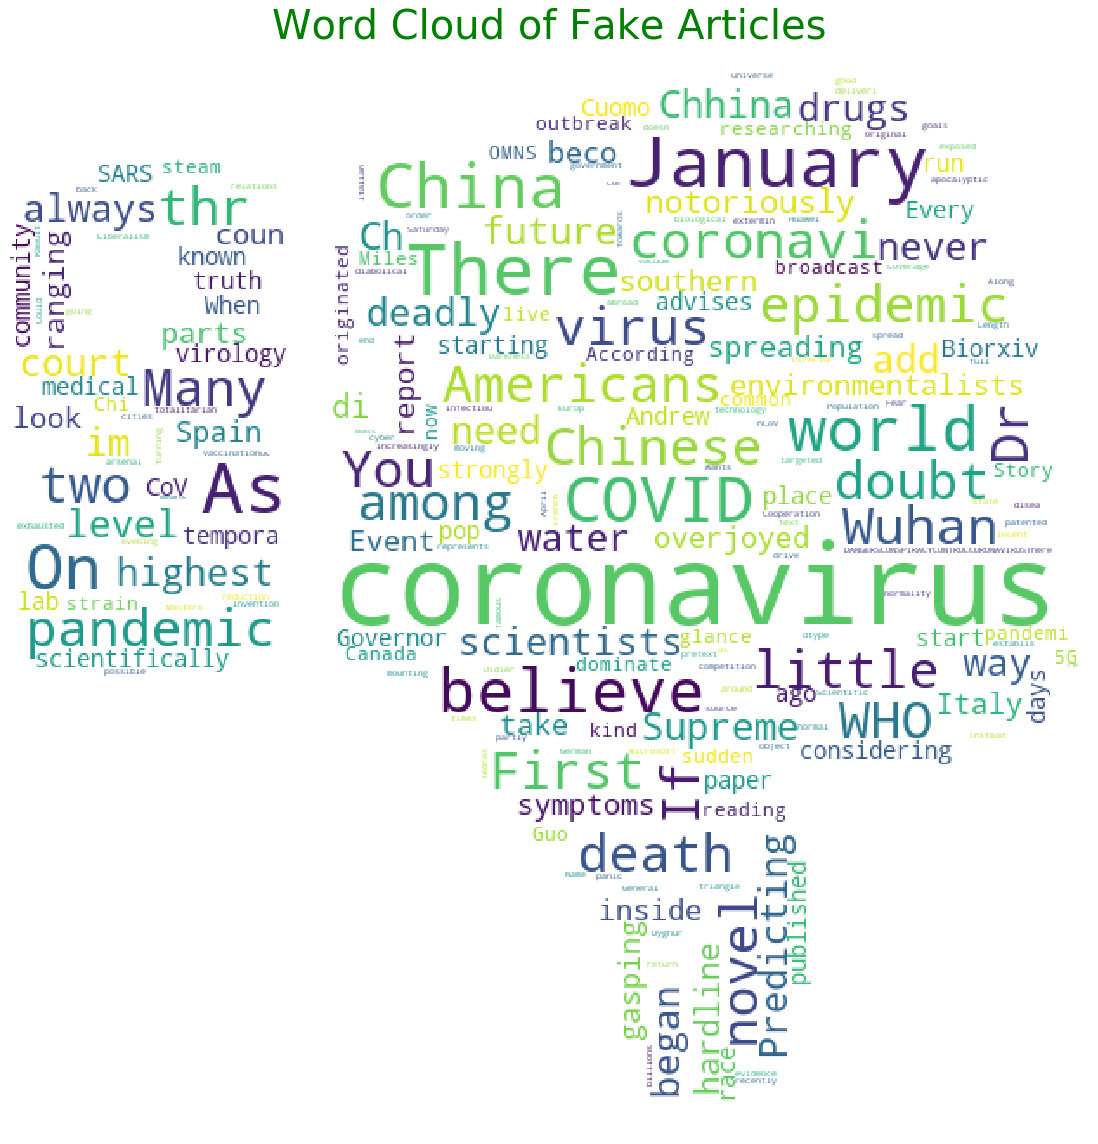

In [14]:
#Word cloud for Fake words
response = requests.get('https://image.freepik.com/free-icon/thumbs-down-silhouette_318-41911.jpg')
upvote_mask = np.array(Image.open(BytesIO(response.content)))#https://raw.githubusercontent.com/manojknit/Natural_Language_Processing/master/images/upvote.png
plot_wordcloud(messages[messages["label"]=="Fake"]["text"], upvote_mask, max_words=300000, max_font_size=300, title="Word Cloud of Fake Articles")

* There seem to be a variety of segregating words. So it is a good idea to look at the most frequent words in each of the classes separately and compare.

### 3/ Word Frequency plot of real and fake news:

In [15]:
from collections import defaultdict
df_real = messages[messages["label"]=='TRUE']
df_fake = messages[messages["label"]=='Fake']

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

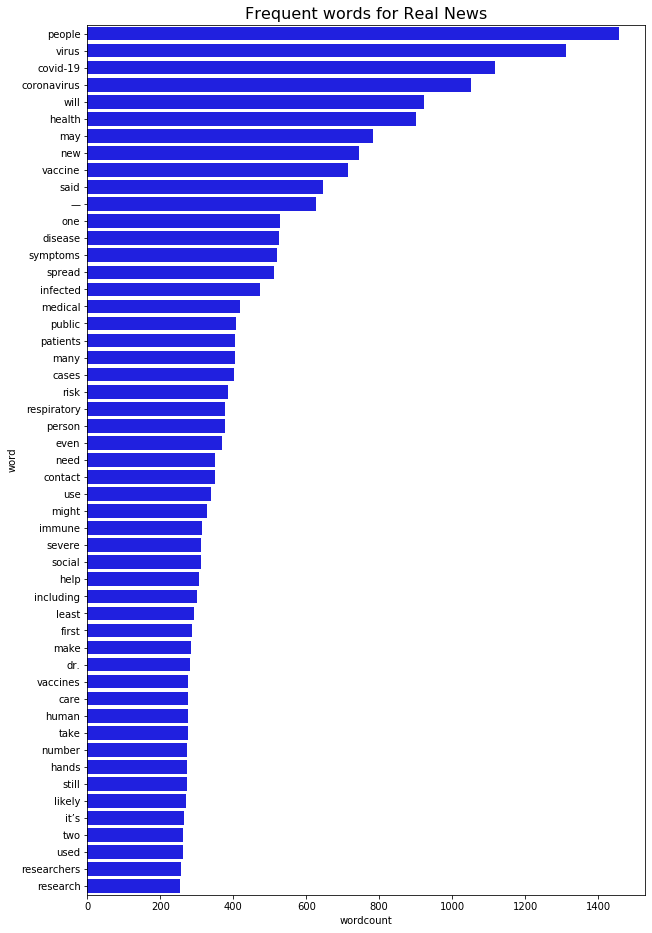

C:\Users\lenovo\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



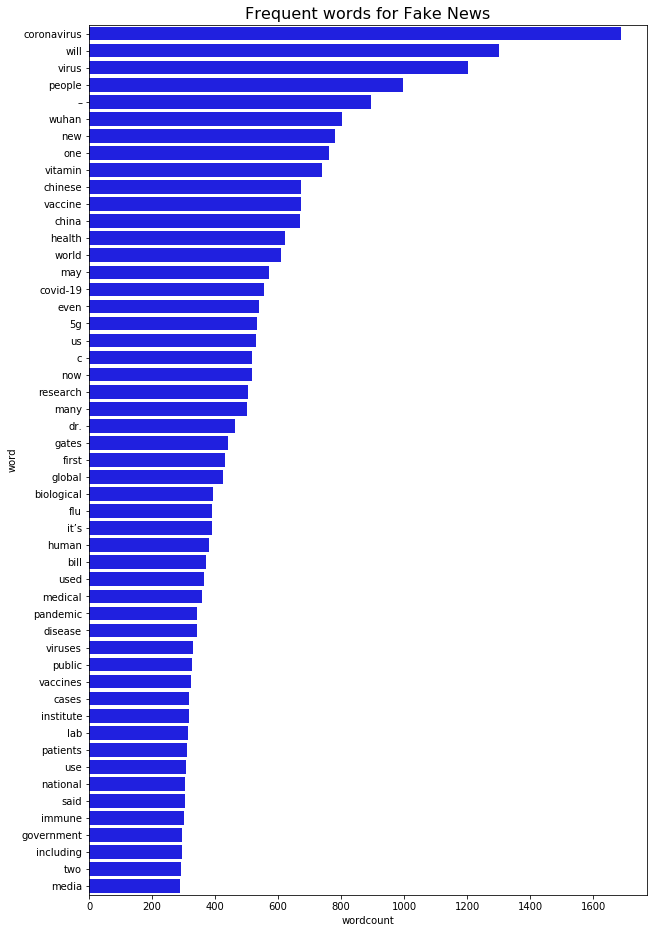

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import tools  # to install $ pip install plotly
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns


## Get the bar chart from real news ##
freq_dict = defaultdict(int)
for sent in df_real["text"]:
    for word in generate_ngrams(sent, 1):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

plt.figure(figsize=(10,16))
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[:50,:], color="b")
plt.title("Frequent words for Real News", fontsize=16)
plt.show()

## Get the bar chart from Fake news ##
freq_dict = defaultdict(int)
for sent in df_fake["text"]:
    for word in generate_ngrams(sent, 1):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of real news", 
                                          "Frequent words of fake news"])

plt.figure(figsize=(10,16))
sns.barplot(x="wordcount", y="word", data=fd_sorted.loc[:50,:], color="b")
plt.title("Frequent words for Fake News", fontsize=16)
plt.show()

### Observations:

* Some of the top words are common across both the classes like 'vaccine', 'coronavirs', 'people' etc
* The other top words in real news after excluding the common ones at the very top are 'health', 'symptomps' etc
* The other top words in fake news after excluding the common ones are 'wuhan', 'chinese' etc

### 4/ Sentiment Polarity difference between Real and Fake News

In [17]:
from textblob import TextBlob
messages['polarity'] = messages['text'].map(lambda text: TextBlob(text).sentiment.polarity)

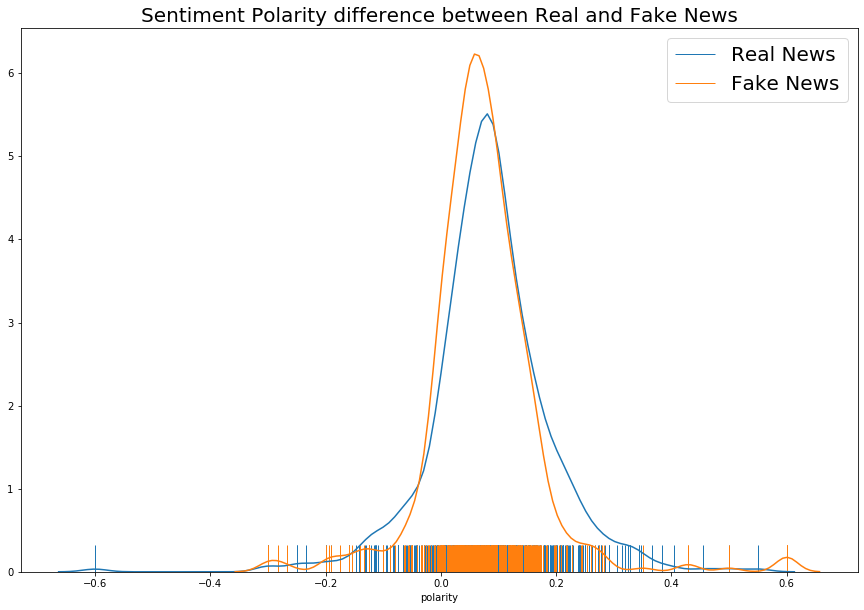

In [18]:
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
%matplotlib inline
x = messages.loc[messages['label']=='TRUE']['polarity']
y = messages.loc[messages['label'] == 'Fake']['polarity']

plt.figure(figsize=(15,10))
plt.title("Sentiment Polarity difference between Real and Fake News", fontsize=20)
sns.distplot(x,rug=True, hist=False)
sns.distplot(y,rug=True, hist=False)
plt.legend(labels=["Real News","Fake News"],prop={'size': 20})





### Observations:
* There isn’t a significant difference in terms of sentiment between true news and fake news. 

### 5/ Meta Features:

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are

* Number of words in the text
* Number of unique words in the text
* Number of characters in the text
* Number of stopwords
* Number of upper case words
* Number of title case words
* Average length of the words

Text(0.5, 1.0, 'Average length of the words in each class')

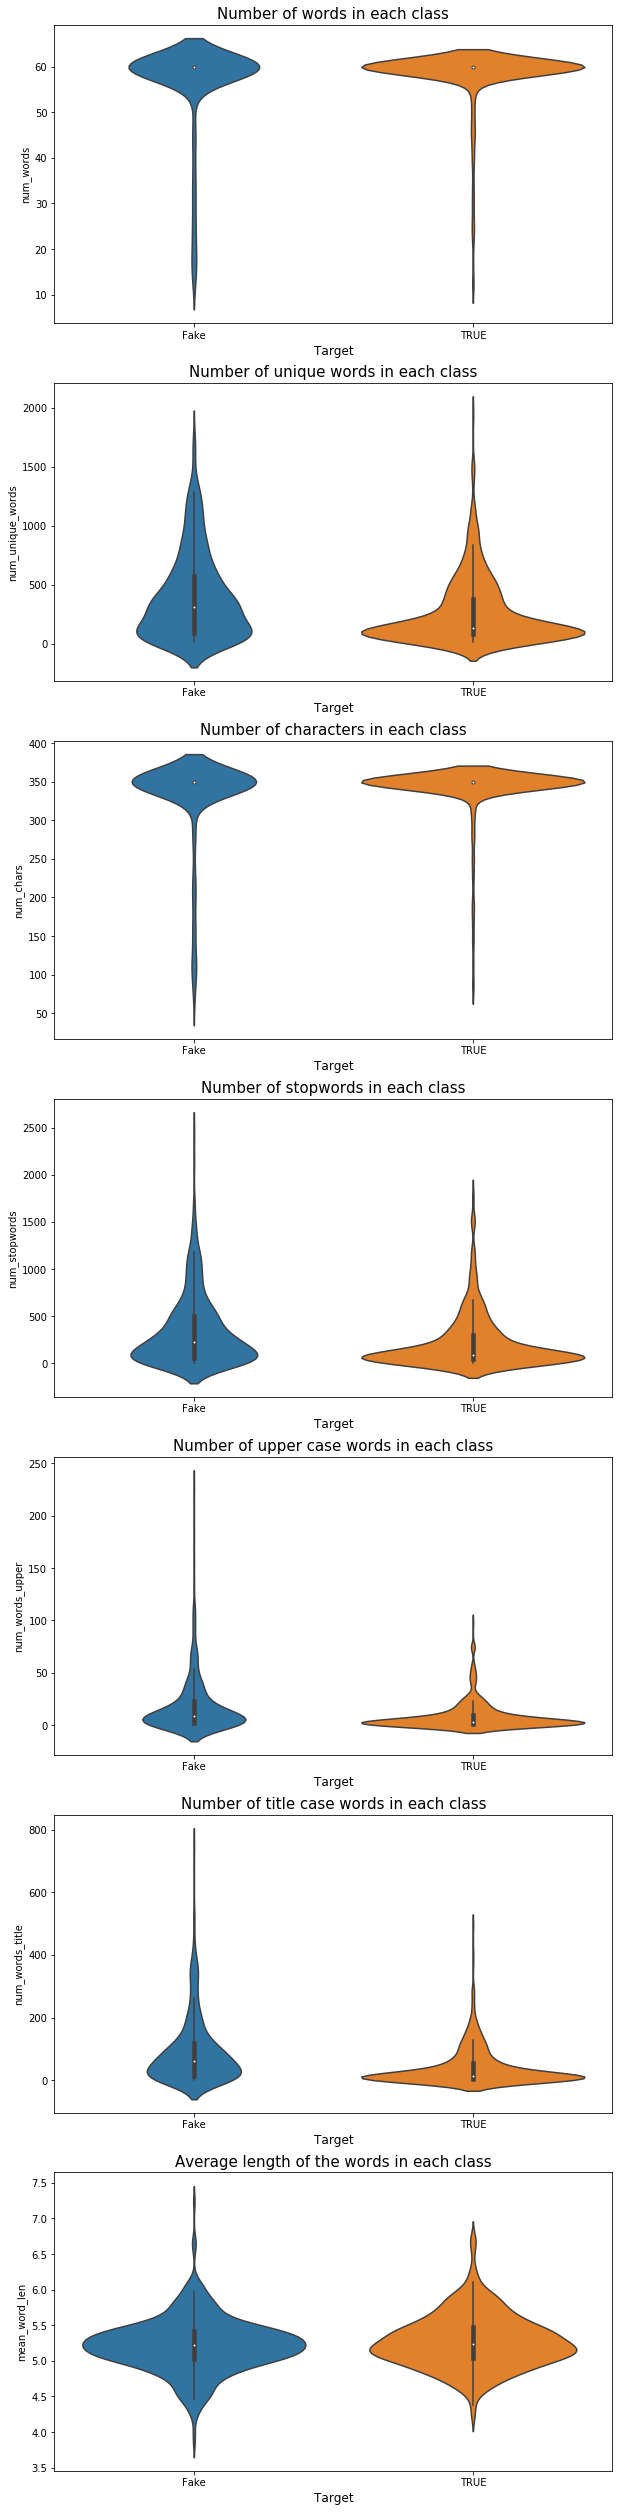

In [19]:
## Number of words in the text ##
messages["num_words"] = messages["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
messages["num_unique_words"] = messages["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
messages["num_chars"] = messages["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
messages["num_stopwords"] = messages["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


## Number of title case words in the text ##
messages["num_words_upper"] = messages["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
messages["num_words_title"] = messages["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
messages["mean_word_len"] = messages["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

import seaborn as sns
color = sns.color_palette()
## Truncate some extreme values for better visuals ##
messages['num_words'].loc[messages['num_words']>60] = 60 #truncation for better visuals
messages['num_chars'].loc[messages['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(7, 1, figsize=(10,45))
sns.violinplot(x='label', y='num_words', data=messages, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.violinplot(x='label', y='num_unique_words', data=messages, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of unique words in each class", fontsize=15)

sns.violinplot(x='label', y='num_chars', data=messages, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of characters in each class", fontsize=15)

sns.violinplot(x='label', y='num_stopwords', data=messages, ax=axes[3])
axes[3].set_xlabel('Target', fontsize=12)
axes[3].set_title("Number of stopwords in each class", fontsize=15)

sns.violinplot(x='label', y='num_words_upper', data=messages, ax=axes[4])
axes[4].set_xlabel('Target', fontsize=12)
axes[4].set_title("Number of upper case words in each class", fontsize=15)

sns.violinplot(x='label', y='num_words_title', data=messages, ax=axes[5])
axes[5].set_xlabel('Target', fontsize=12)
axes[5].set_title("Number of title case words in each class", fontsize=15)

sns.violinplot(x='label', y='mean_word_len', data=messages, ax=axes[6])
axes[6].set_xlabel('Target', fontsize=12)
axes[6].set_title("Average length of the words in each class", fontsize=15)


* From all the graphs above we can say that both Fake articles and real articles have a very similiar structure : a large amount of words used, not much of stopwords used, the higher number of characters used, the average length of the words are between 4.5 and 6.0 ...
* But we can observe some differences such as the number of unique words used in fake articles is higher than the real articles. Also the number of upper case words used in fake articles is higher then the real articles.

## III/ Classification :

* Creating the corpus and the bag of words

In [20]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [21]:
corpus[3]

'common symptom covid dri cough tired fever peopl may develop sever form diseas pneumonia best way confirm viru produc covid diseas laboratori test cannot confirm breath exercis even danger'

In [22]:
## Applying Countvectorizer
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [23]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=0)

In [24]:
count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())
count_df.head()

,abandon,abil,abl,abl infect,abnorm,abroad,absenc,absolut,absorb,absorpt,...,zelenko,zero,zero hedg,zerohedg,zhengli,zhou,zika,zinc,zone,zoonot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1/ MultinomialNB Algorithm

accuracy:   0.943
Confusion matrix, without normalization


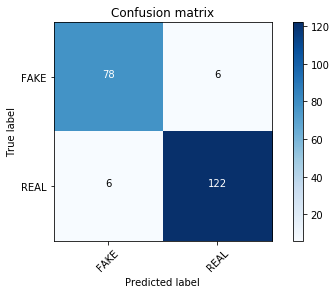

In [26]:
from sklearn import metrics
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(X_train, y_train)
pred_MultiNB = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred_MultiNB)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_MultiNB)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 2/ Multinomial Classifier with Hyperparameter

In [27]:
classifier1=MultinomialNB(alpha=0.1)
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train,y_train)
    y_pred=sub_classifier.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Alpha: 0.0, Score : 0.9433962264150944
Alpha: 0.1, Score : 0.9481132075471698
Alpha: 0.2, Score : 0.9481132075471698
Alpha: 0.30000000000000004, Score : 0.9433962264150944
Alpha: 0.4, Score : 0.9433962264150944
Alpha: 0.5, Score : 0.9433962264150944
Alpha: 0.6000000000000001, Score : 0.9433962264150944
Alpha: 0.7000000000000001, Score : 0.9433962264150944
Alpha: 0.8, Score : 0.9433962264150944
Alpha: 0.9, Score : 0.9433962264150944


=> Best Accuracy with Alpha = 0.1 or 0.2

accuracy:   0.948
Confusion matrix, without normalization


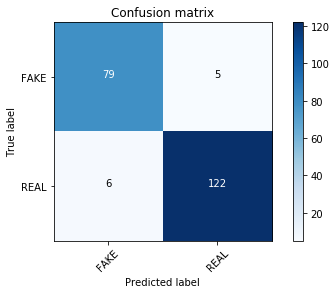

In [28]:
from sklearn import metrics
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB
classifier_MNB=MultinomialNB(alpha=0.1)
classifier_MNB.fit(X_train, y_train)
pred_MNB = classifier_MNB.predict(X_test)
score = metrics.accuracy_score(y_test, pred_MNB)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_MNB)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### 3/ Passive Aggressive Classifier Algorithm

accuracy:   0.873
Confusion matrix, without normalization


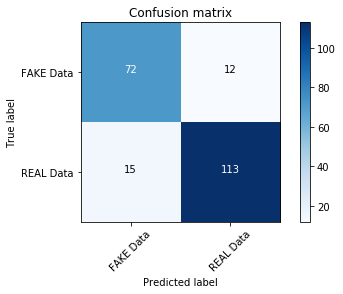

In [29]:
### 3/ Passive Aggressive Classifier Algorithm
from sklearn import metrics
import numpy as np
import itertools
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier()
linear_clf.fit(X_train, y_train)
pred_PAC = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred_PAC)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_PAC)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 4/ Logistic Regression

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



accuracy:   0.901
Confusion matrix, without normalization


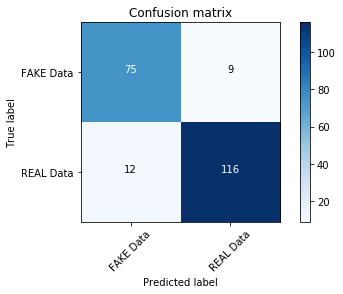

In [30]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred_LOG = logmodel.predict(X_test)
score = metrics.accuracy_score(y_test, pred_LOG)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_LOG)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 5/ Naive Bayes

accuracy:   0.901
Confusion matrix, without normalization


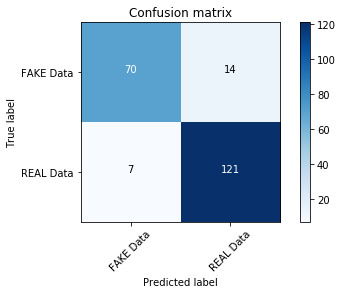

In [31]:
from sklearn.naive_bayes import GaussianNB
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)
pred_NB = classifier_NB.predict(X_test)
score = metrics.accuracy_score(y_test, pred_NB)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_NB)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 6/ Decision Tree :

accuracy:   0.816
Confusion matrix, without normalization


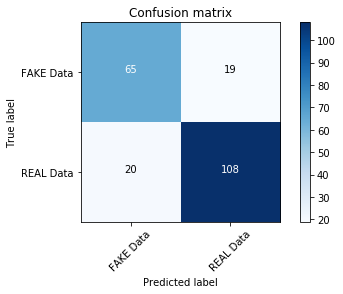

In [32]:
from sklearn.tree import DecisionTreeClassifier
decclassifier = DecisionTreeClassifier(criterion ='entropy')
decclassifier.fit(X_train, y_train)
pred_DT = decclassifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred_DT)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_DT)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 7/ Random Forest

accuracy:   0.892
Confusion matrix, without normalization


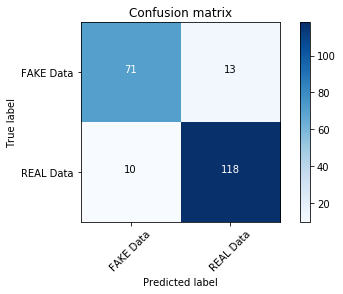

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train, y_train)
pred_RF = rfc.predict(X_test)
score = metrics.accuracy_score(y_test, pred_RF)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_RF)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 8/ svm

accuracy:   0.670
Confusion matrix, without normalization


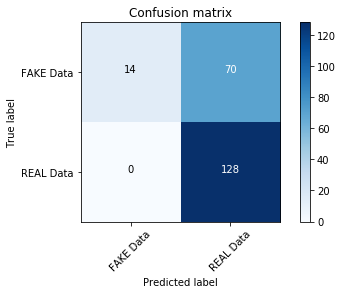

In [34]:
from sklearn.svm import SVC
svcclassifier = SVC(kernel = 'rbf', random_state = 0, gamma=0.8, C=100, probability=True)
svcclassifier.fit(X_train, y_train)
pred_SVM = svcclassifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred_SVM)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_SVM)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 9/ XGBoost

accuracy:   0.910
Confusion matrix, without normalization


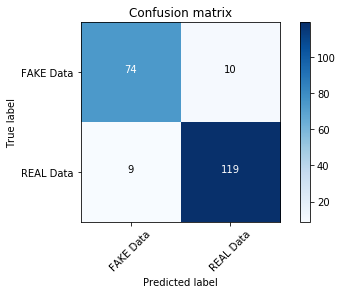

In [35]:
from xgboost import XGBClassifier
xgclassifier = XGBClassifier()
xgclassifier.fit(X_train, y_train)
pred_XGB = xgclassifier.predict(X_test)
score = metrics.accuracy_score(y_test, pred_XGB)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred_XGB)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

### 10/ Models comparison

### Comparatif table of the accuracy score

In [36]:
acc_multiNB=metrics.accuracy_score(y_test, pred_MultiNB)
acc_mnb=metrics.accuracy_score(y_test, pred_MNB)
acc_pac=metrics.accuracy_score(y_test, pred_PAC)
acc_log=metrics.accuracy_score(y_test, pred_LOG)
acc_NB=metrics.accuracy_score(y_test, pred_NB)
acc_dt=metrics.accuracy_score(y_test, pred_DT)
acc_rfc=metrics.accuracy_score(y_test, pred_RF)
acc_svc=metrics.accuracy_score(y_test, pred_SVM)
acc_XGBoost=metrics.accuracy_score(y_test, pred_XGB)
models = pd.DataFrame({
    'Model': ['MultinomialNB',  
              'MultinomialNB with alpha=0.1', 
              'Passive Aggressive Classifier Algorithm',
              'Logistic Regression',
              'Naive Bayes',
              'Decision Tree',
              'Random Forest',
              'Support Vector Machines',
              'XGBoost'],
    'Score': [acc_multiNB,acc_mnb, acc_pac, 
              acc_log, acc_NB, acc_dt, 
              acc_rfc, acc_svc,acc_XGBoost]})
models.sort_values(by="Score",ascending=False)

,Model,Score
1,MultinomialNB with alpha=0.1,0.948113
0,MultinomialNB,0.943396
8,XGBoost,0.910377
3,Logistic Regression,0.900943
4,Naive Bayes,0.900943
6,Random Forest,0.891509
2,Passive Aggressive Classifier Algorithm,0.872642
5,Decision Tree,0.816038
7,Support Vector Machines,0.669811


### Roc Curve

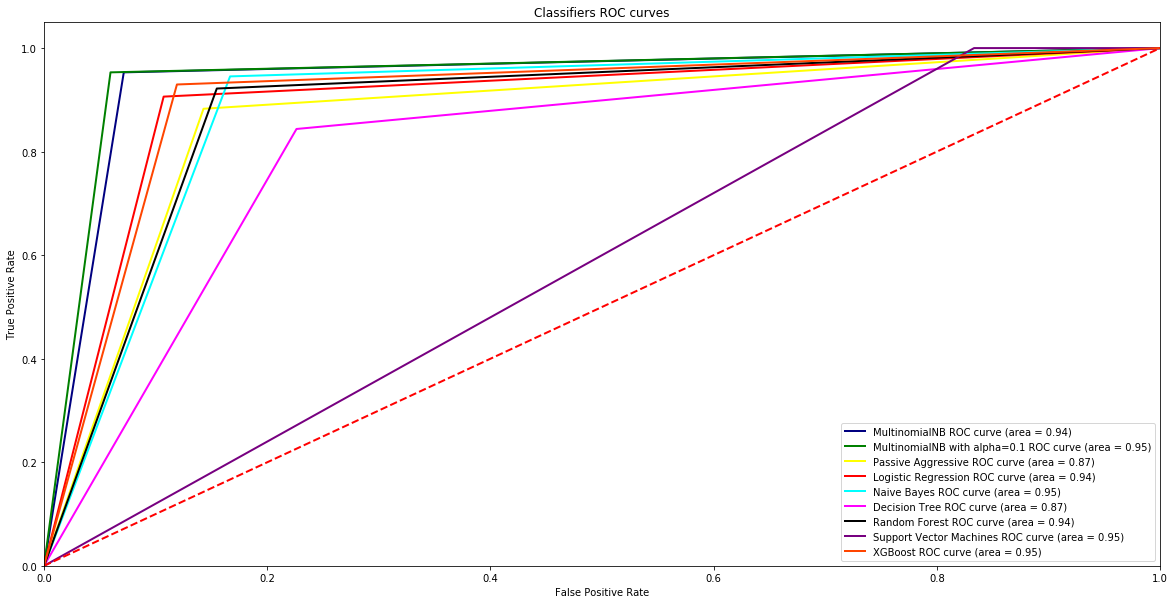

In [37]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test, pred_MultiNB) 
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_MNB) 
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_PAC)
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, threshold4 = roc_curve(y_test, pred_LOG) 
roc_auc4 = auc(fpr4, tpr4)
fpr5, tpr5, threshold5 = roc_curve(y_test, pred_NB) 
roc_auc5 = auc(fpr5, tpr5)
fpr6, tpr6, threshold6 = roc_curve(y_test, pred_DT)
roc_auc6 = auc(fpr6, tpr6)
fpr7, tpr7, threshold7 = roc_curve(y_test, pred_RF) 
roc_auc7 = auc(fpr7, tpr7)
fpr8, tpr8, threshold8 = roc_curve(y_test, pred_SVM)
roc_auc8 = auc(fpr8, tpr8)
fpr9, tpr9, threshold9 = roc_curve(y_test, pred_XGB)
roc_auc9 = auc(fpr9, tpr9)


plt.figure(figsize=(20,10)) 
plt.plot(fpr1, tpr1, color='navy', lw=2, label='MultinomialNB ROC curve (area = %0.2f)'% roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='MultinomialNB with alpha=0.1 ROC curve (area = %0.2f)'% roc_auc2)
plt.plot(fpr3, tpr3, color='yellow', lw=2, label='Passive Aggressive ROC curve (area = %0.2f)'% roc_auc3)

plt.plot(fpr4, tpr4, color='red', lw=2, label='Logistic Regression ROC curve (area = %0.2f)'% roc_auc1)
plt.plot(fpr5, tpr5, color='cyan', lw=2, label='Naive Bayes ROC curve (area = %0.2f)'% roc_auc2)
plt.plot(fpr6, tpr6, color='magenta', lw=2, label='Decision Tree ROC curve (area = %0.2f)'% roc_auc3)
plt.plot(fpr7, tpr7, color='black', lw=2, label='Random Forest ROC curve (area = %0.2f)'% roc_auc1)
plt.plot(fpr8, tpr8, color='#770080', lw=2, label='Support Vector Machines ROC curve (area = %0.2f)'% roc_auc2)
plt.plot(fpr9, tpr9, color='#FF4500', lw=2, label='XGBoost ROC curve (area = %0.2f)'% roc_auc2)


plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Classifiers ROC curves') 
plt.legend(loc = "lower right")
plt.show()

=> From the ROC curve and the comparatif table of the accuracy we can deduce that the best model is MultinomialNB with alpha=0.1.

### 11/ Testing the best model (MultinomialNB with alpha=0.1):

In [45]:
txt_exemple="PolitiFact, FactCheck.org and the CBC (Canadian Broadcasting Corporation) have concluded that there has been no evidence that the new coronavirus was stolen by Chinese spies from a Canadian laboratory. The allegation is based on the fact that two Chinese scientists were expelled from this laboratory in July 2019, which is correct, as reported by the CBC. However, the Public Health Agency of Canada told the CBC that they were asked to leave because of an investigation into what the agency described as a rule violation and an administrative matter  She added that the case was not related to the coronavirus epidemic. This is misinformation, and there is no factual basis for these allegations that are made on social networks, said Eric Morrissette, spokesperson for the Public Health Agency of Canada, at the CBC in January 2020"
print("Please paste the article that you want to verify :" )
print("---------------------------------------------------")
txt=input()
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
review = re.sub('[^a-zA-Z]', ' ', txt)
review = review.lower()
review = review.split()
    
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
corpus.append(review)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X2 = cv.fit_transform(corpus).toarray()

pred2 = classifier_MNB.predict(X2)
if(pred2[len(pred2)-1]==0):
    print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("=> This article is Fake" )
else:
    print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("=> This article is Real")

Please paste the article that you want to verify :
---------------------------------------------------


 -For weeks, talking heads have been promoting the liability-free vaccine(s) that will save the world—so Bill Gates and Tony Fauci proclaim—from what Gates has now dubbed “Pandemic I.” As Microsoft News peddles self-congratulatory stories about the Gates Foundation’s reorientation of its priorities to devote “‘total attention’ to the pandemic,” Fauci—making the rounds of talk shows—pledges that a vaccine will make its debut in January 2021. Not to be outdone, the White House has now unveiled “Operation Warp Speed”—a joint pharmaceutical-government-military effort aimed at “substantially shrinking the development time for a vaccine”—and President Trump promises one by the end of the year.Planet-wide COVID-19 vaccination—the overt objective that has all of these players salivating in anticipation—ignores a number of irrefutable obstacles. For one, the RNA virus being targeted, SARS-CoV-2, already “has mutated into at least 30 different genetic variants.” The variants include 19 never see

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
=> This article is Fake
